## EfficientNet Pre-Trained with PyTorch - Covid-19 X-Ray Dataset

# [Link to my Youtube Video Explaining this whole Notebook](https://youtu.be/WJh3diVLUcY?list=PLxqBkZuBynVRyOJs4RWmB_fKlOVe5S8CR)

[![Imgur](https://imgur.com/QrqgGHt.png)](https://youtu.be/WJh3diVLUcY?list=PLxqBkZuBynVRyOJs4RWmB_fKlOVe5S8CR)

EfficientNet is a convolutional neural network architecture and scaling method developed by Google in 2019. It has been shown to surpass state-of-the-art accuracy with up to 10 times better efficiency (i.e. smaller and faster).
The graphs below illustrate how EfficientNet (red line) outperforms other architectures in terms of accuracy (on ImageNet) and computing resources.

![Imgur](https://imgur.com/6wFT36N.png)

##### [Dataset used for this Notebook ](https://www.kaggle.com/pranavraikokte/covid19-image-dataset)

![Imgur](https://imgur.com/qmrWuUp.png)

The different versions of EfficientNet (b0 to b7) differ based on the number of model parameters. A higher number of parameters leads to greater accuracy, but at the expense of longer training time.
For this tutorial, we will use the PyTorch implementation of EfficientNet to set up an EfficientNet-B0 architecture with Pre-Trained Weights.


In [ ]:
# The below 3 Installation was required in Kaggle Kernel
# !pip install --upgrade --force-reinstall --no-deps torch
# !pip install --upgrade --force-reinstall --no-deps torchvision
!pip install timm

In [2]:
!nvidia-smi

Sat Feb 12 12:27:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from tqdm import tqdm
import time
import copy
import timm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import timm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device='cpu'
device

device(type='cuda')

In [4]:
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


In [5]:
# Colab path from G-Drive
ROOT_PATH = "/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/"

# Kaggle Root Path
# ROOT_PATH = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/"

# Local Machine
# ROOT_PATH = "../../Datasets/Covid-19-Image-Dataset-170MB/"

#  Image size is not same throughout the whole dataset. Therefore all the images has been resized to 256 X 256 size using the Resize() function

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Plotting images

In [7]:
train_dir = os.path.join(ROOT_PATH, 'train')

train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')

train_covid_fnames = os.listdir(train_covid_dir)
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

print(train_covid_fnames[:10])
print(train_normal_fnames[:10])
print(train_pneumonia_fnames[:10])

['01.jpeg', '010.png', '012.jpeg', '015.jpg', '019.png', '02.jpeg', '043.jpeg', '024.jpeg', '025.jpeg', '031.jpeg']
['013.jpeg', '012.jpeg', '01.jpeg', '018.jpeg', '015.jpeg', '016.jpeg', '017.jpeg', '019.jpeg', '010.jpeg', '011.jpeg']
['022.jpeg', '036.jpeg', '027.jpeg', '046.jpeg', '048.jpeg', '032.jpeg', '044.jpeg', '043.jpeg', '047.jpeg', '023.jpeg']


In [8]:
# nrows = 6
# ncols = 4

# pic_index = 0 # Index for iterating over images

# fig = plt.gcf()
# fig.set_size_inches(ncols*4, nrows*4)

# pic_index += 8

# covid_img_path_list = [os.path.join(train_covid_dir, fname) 
#                 for fname in train_covid_fnames[ pic_index-8:pic_index] ]
# covid_img_path_list

covid_img_path_list ['/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/train/Covid/01.jpeg', '/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/train/Covid/010.png', '/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/train/Covid/012.jpeg', '/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/train/Covid/015.jpg', '/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/train/Covid/019.png', '/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/train/Covid/02.jpeg', '/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/train/Covid/043.jpeg', '/content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/train/Covid/024.jpeg']


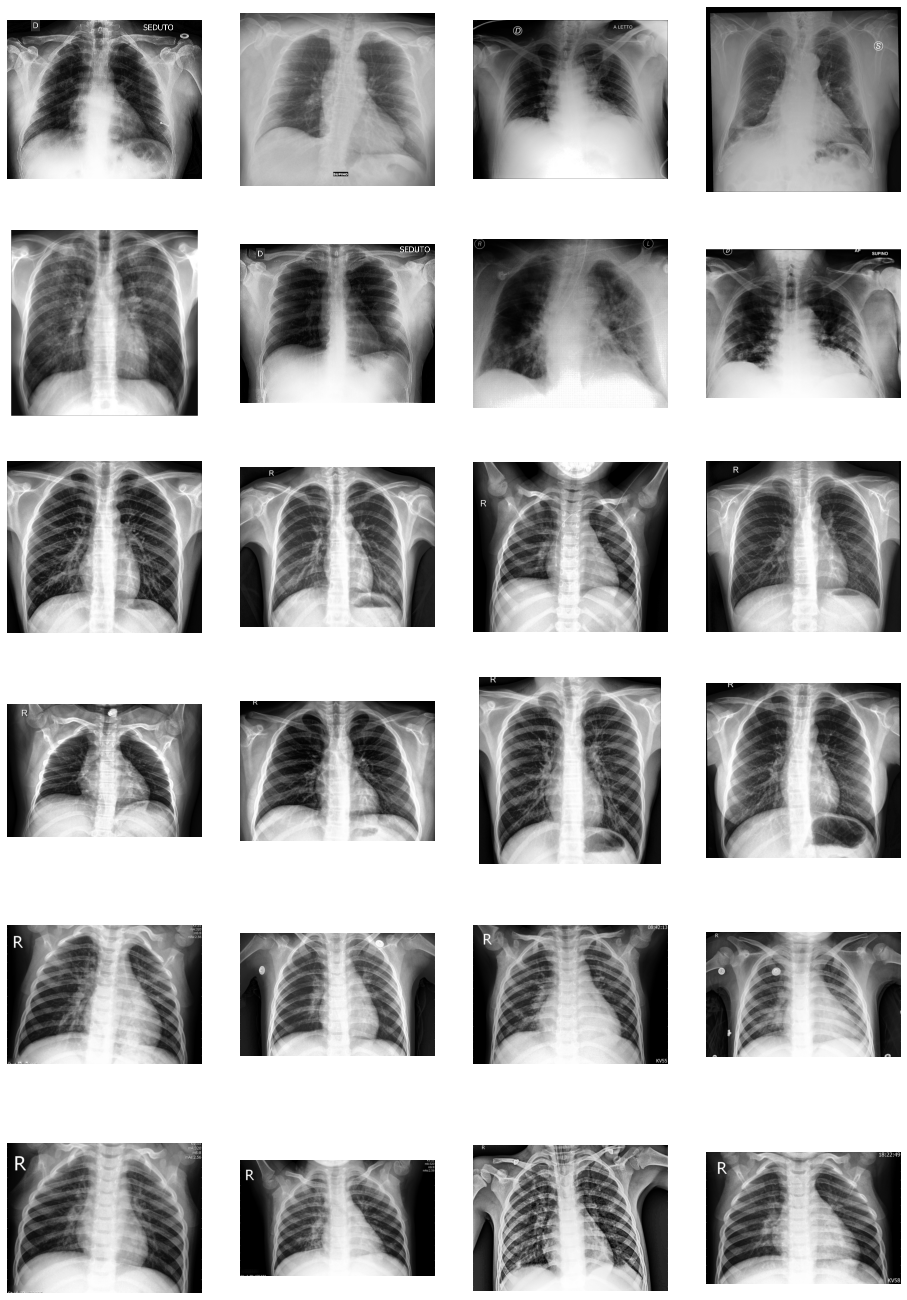

In [9]:

nrows = 6
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

covid_img_path_list = [os.path.join(train_covid_dir, fname) 
                for fname in train_covid_fnames[ pic_index-8:pic_index] ]
print("covid_img_path_list", covid_img_path_list)


normal_img_list = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

pneumonia_img_list = [os.path.join(train_pneumonia_dir, fname) 
                for fname in train_pneumonia_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(covid_img_path_list+normal_img_list+pneumonia_img_list):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Dataset Loader Function with various Augmentations

#### Reason for choosing `transforms.Resize(256)` and `transforms.CenterCrop(224)` - 

Checkout the [Official Code here](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93)

```py

elif args.model.startswith('efficientnet_'):
        sizes = {
            'b0': (256, 224), 'b1': (256, 240), 'b2': (288, 288), 'b3': (320, 300),
            'b4': (384, 380), 'b5': (489, 456), 'b6': (561, 528), 'b7': (633, 600),
        }

```

In [10]:
def get_dataset_loader(data_path, batch_size=256, train=False):
  """  Get the dataset loader for training or testing.

    Parameters:
    - data_path (str): Path to the dataset directory.
    - batch_size (int): Batch size for the dataloader.
    - train (bool): Whether to get the training dataset loader or testing dataset loader.

    Returns:
    - dataloader (torch.utils.data.DataLoader): Dataset loader.
    - dataset_size (int): Size of the dataset. """
  if train:
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), transforms.GaussianBlur(3)]), p=0.1),
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
      transforms.RandomErasing(p=0.12, value='random')
    ])

    train_imgs = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/'), transform=transform)

    print(f"We have {len(train_imgs)} Training Images with {len(train_imgs.classes)} classes")

    len_train_images = int(len(train_imgs) * 0.78)
    
    len_validation_images = int(len(train_imgs) - len_train_images )

    train_dataset, validation_dataset = random_split(train_imgs, [len_train_images, len_validation_images] )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_dataloader, validation_dataloader, len(train_dataset), len(validation_dataset)

  else:
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
  ])
  
  test_imgs = datasets.ImageFolder(os.path.join(ROOT_PATH, 'test/'), transform=transform)
  
  print(f"We have {len(test_imgs)} Training Images with {len(test_imgs.classes)} classes")
  
  test_dataloader = DataLoader(test_imgs, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  
  return test_dataloader, len(test_imgs)
    


## Explanations of above Block of Code

## How Torchvision dataset ImageFolder works ?

ImageFolder is a generic data loader class in torchvision that helps you load your own image dataset.

As the first requirement, the input data should be in a different folder per label for the default PyTorch ImageFolder to load it correctly. Like - train/dog, - train/cat, - test/dog, - test/cat and then passing the train and the test folder to the train and test ImageFolder respectively.


So if the directory is given as explained above, we only need to initialize an instance of ImageFolder class with the root. The instance will return the randomly selected and transformed batch with corresponding labels.

 ## Transform

In order to augment the dataset, we apply various transformation techniques. These include the crop, resize, rotation, translation, flip and so on. In the pyTorch, those operations are defined in the ‘torchvision.transforms’

Generally, transformation does help the model to prevent the overfitting issue. However sometime in cases, where there is no  overfitting issue in the model, after applying a lot of transformation, the training loss and validation loss may actually worsen.


#### RandomHorizontalFlip

This transformation will flip the image horizontally (random) with a given probability. You can set this probability through the parameter ‘p’. The default value of p is 0.5.

#### RandomRotation
This transformation rotates the image randomly by an angle. The angle in degrees can be provided as input to that parameter “degrees”.

```py

transform = transforms.Compose([transforms.RandomRotation(degrees=180)])
tensor_img = transform(image)

```

#### RandomVerticalFlip(p):

This function will flip the given image vertically in random with a given probability.

#### RandomPerspective(distortion_scale, p):

This unction will perform perspective transformation of the given image randomly given a probability. It reduces the effect of perspective for model learning by distorting whole the image.

![Imgur](https://imgur.com/lFO4zCs.png)


#### ColorJitter(brightness, contrast, saturation, hue):

I can randomly change the brightness, contrast and saturation of an image


#### CenterCrop

Crops the given image at the center. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions. If image size is smaller than output size along any edge, image is padded with 0 and then center cropped.

**transforms.ToTensor()** convert data array to Pytorch tensor. Advantage include easy to use in CUDA, GPU training.

--------------------------------------------------------
### Why Pytorch officially use mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] to normalize images ?

First the normalization works as below to modify the input training dataset's channel values

#### input[channel] = (input[channel] - mean[channel]) / std[channel]

The mean and standard deviation values are to be taken from the training dataset.

Per [Doc](https://pytorch.org/vision/stable/models.html) -

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

This is because, the above values for Normalization() is calculated based on the ImageNet Dataset.


Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images. If you want to train from scratch on your own dataset, you can calculate the new mean and std. Otherwise, using the Imagenet pretrianed model with its own mean and std is recommended.

Further on this point, whether or not to use ImageNet's mean and stddev depends on your data. Assuming your data are ordinary photos of "natural scenes"† (people, buildings, animals, varied lighting/angles/backgrounds, etc.), and assuming your dataset is biased in the same way ImageNet is (in terms of class balance), then it's ok to normalize with ImageNet's scene statistics. If the photos are "special" somehow (color filtered, contrast adjusted, uncommon lighting, etc.) or an "un-natural subject" (medical images, satellite imagery, hand drawings, etc.) then you need to experiment with the respective training dataset's own mean and standard deviation values.

Example code for using values of (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

```py
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
```

And in case you are using new Mean and Variance from your own training dataset - then don't forget to scale the validation and test set using the mean and variance of the training set, rather than their own mean and variance. Otherwise you introduce a domain shift.

Domain shift refers to the difference in the data distribution of two datasets, normally between the training set and the test set.

## Get Number of Classes

In [11]:
class_categories = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/')).classes
# ['Covid', 'Normal', 'Viral Pneumonia']
num_classes = len(class_categories)
num_classes

3

### Display a random image

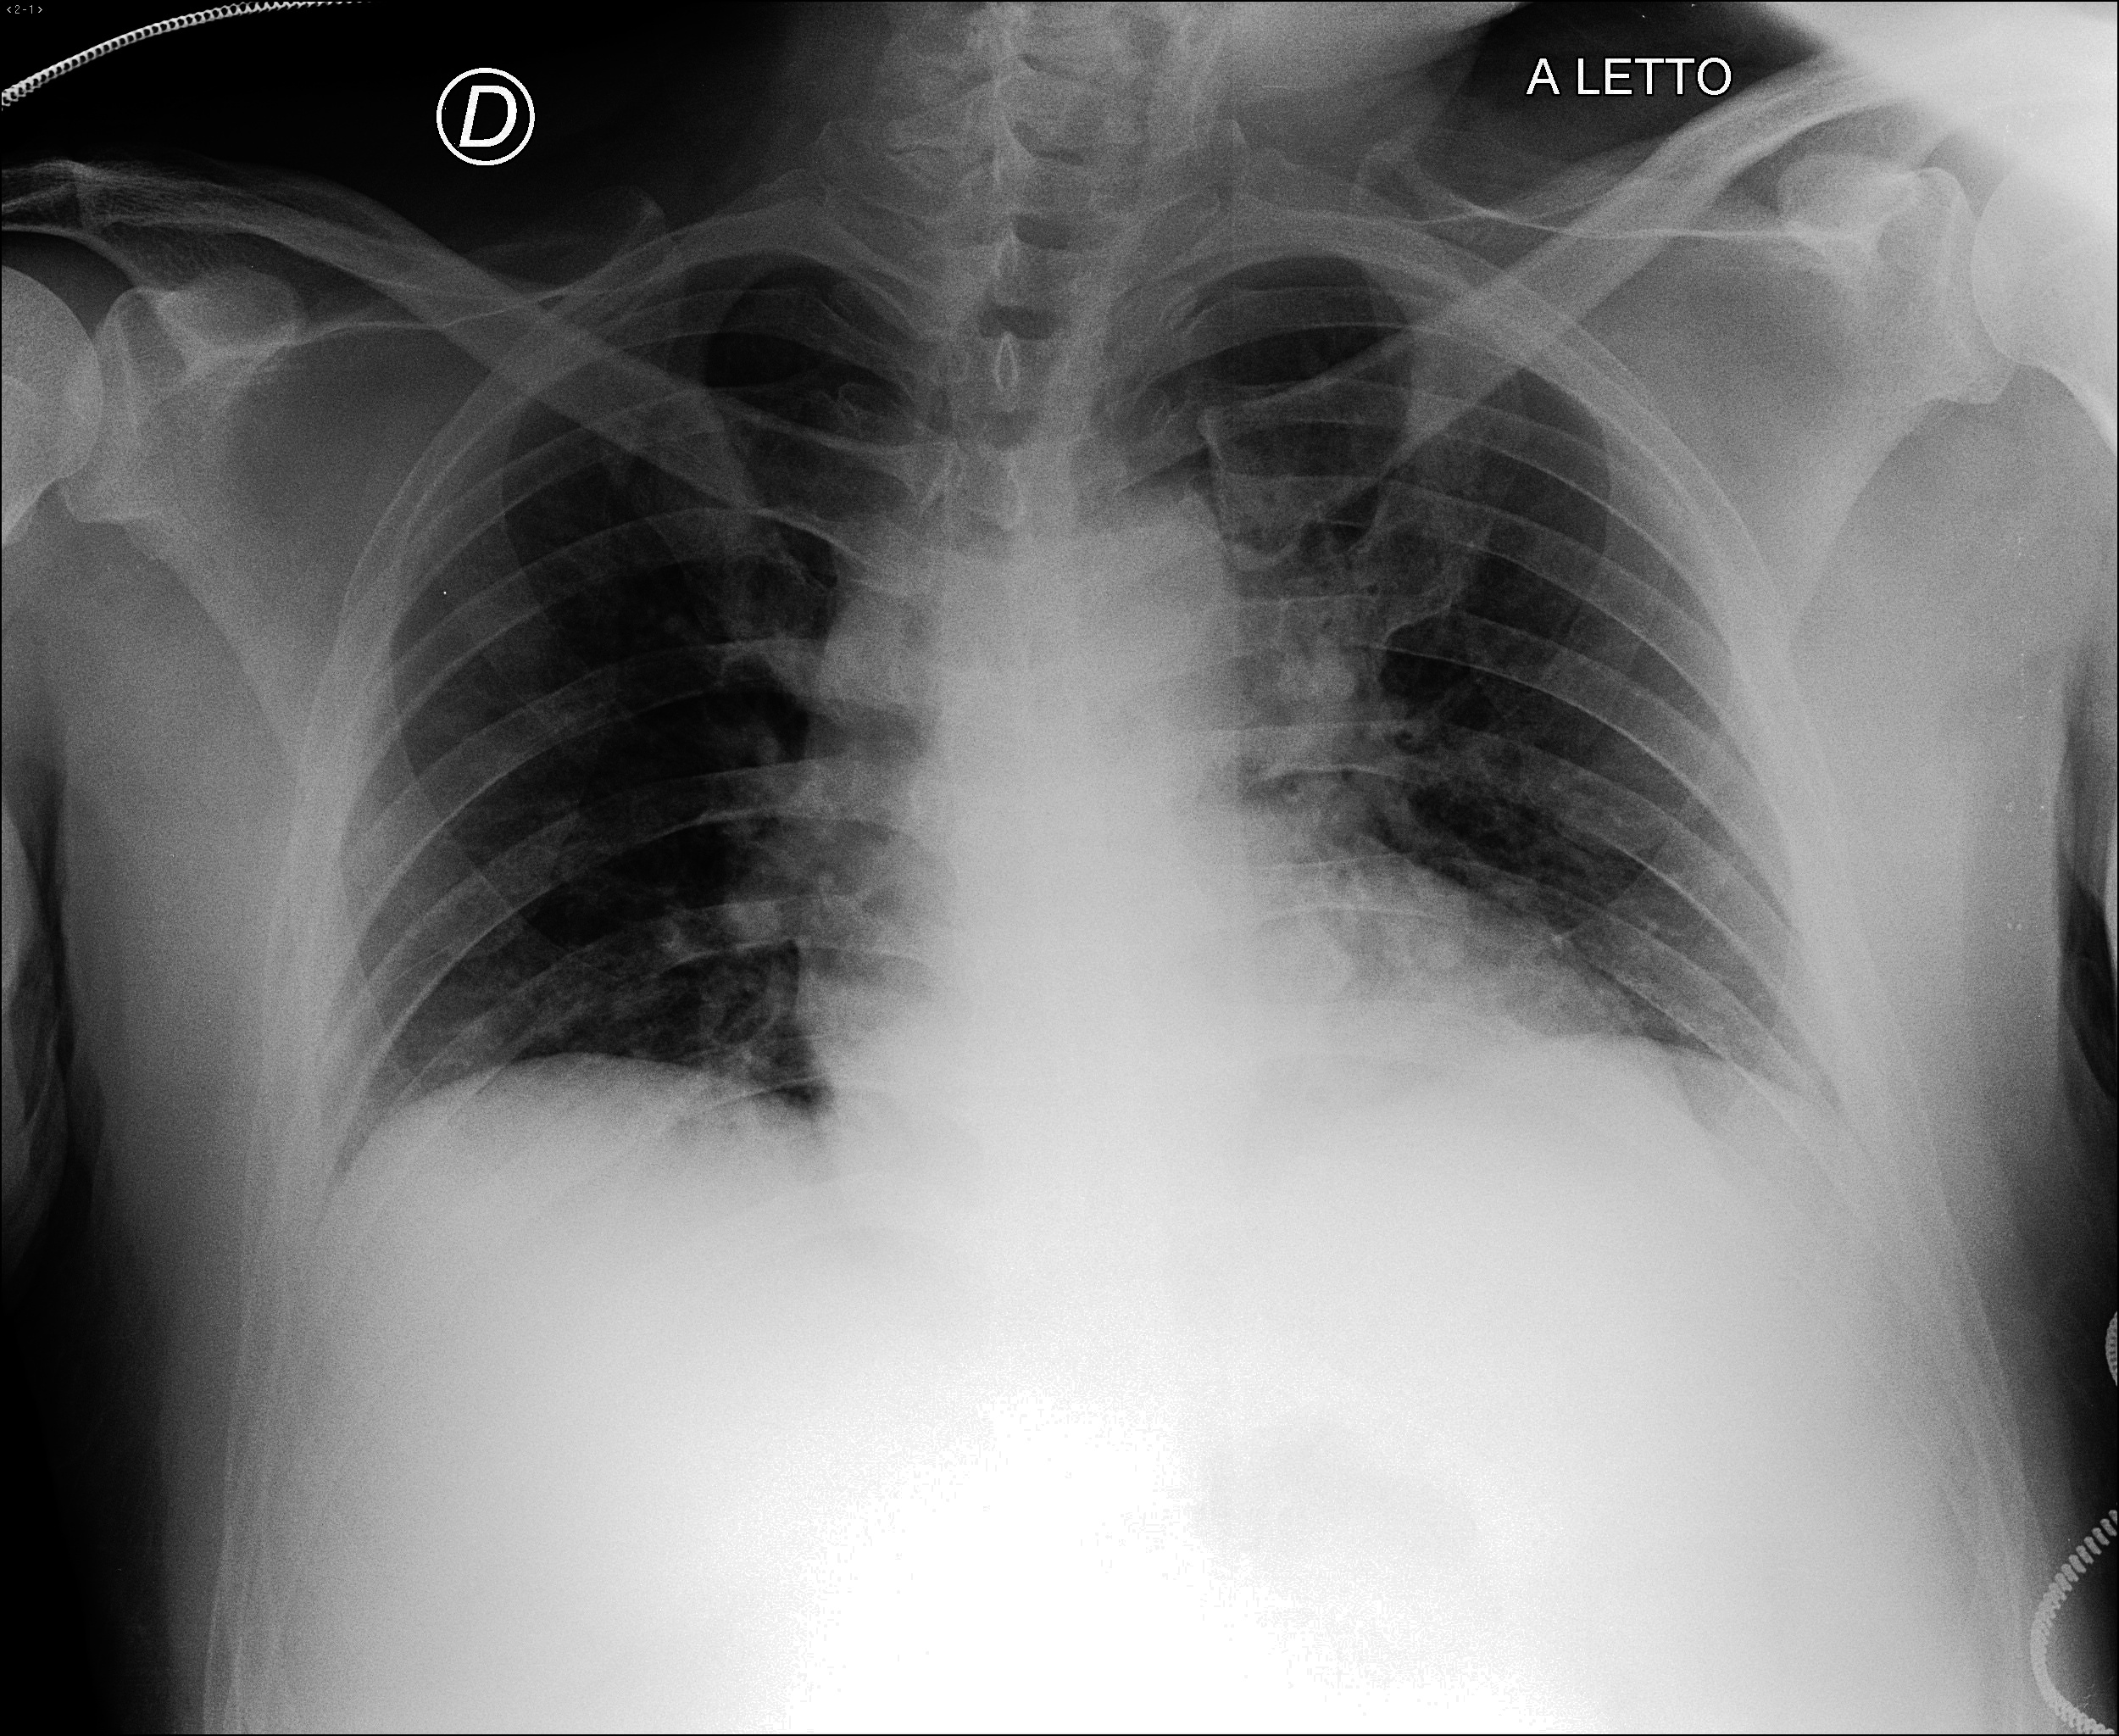

In [12]:
train_data = datasets.ImageFolder(os.path.join(ROOT_PATH, 'train/'))
train_data[2][0]

## Invoke the previous get_dataset_loader() Function to get all my loaders (train, test and valid)

In [13]:
BATCH_SIZE = 32

(train_dataloader, validation_dataloader, len_train_dataloader, len_validation_dataloader) = get_dataset_loader(ROOT_PATH, batch_size=BATCH_SIZE, train=True)

(test_dataloader, len_test_dataloader) = get_dataset_loader(ROOT_PATH, batch_size=BATCH_SIZE, train=False)

We have 251 Training Images with 3 classes
We have 66 Training Images with 3 classes


In [14]:
train_dataloader.dataset

In [15]:
test_dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 66
    Root location: /content/drive/MyDrive/All_Datasets/Covid-19-Image-Dataset-170MB/Covid19-dataset/test/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.466), std=(0.229, 0.224, 0.255))
           )

In [16]:
print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))
print(len_train_dataloader, len_validation_dataloader, len_test_dataloader )

7
2
3
195 56 66


In [17]:
dataloaders_dict = {
  'train': train_dataloader,
  'validation': validation_dataloader
}

dataset_sizes_dict = {
  'train':len_train_dataloader,
  'validation': len_validation_dataloader
}

## Now that all the augmentation are applied, Plot some of those augmented images

#### What does next() and iter() do in PyTorch's DataLoader()

Basically iter() calls the `__iter__()` method on the train_loader.

#### Now `train_dataloader` is an iterable or python iterator, and passing it to `iter()` returns an iterator which you can iterate trough.

So `train_dataloader` will return elements from your dataset batch by batch. This allows you to use it as for data in train_loader.


`next()` then calls the `__next__()` method on that iterator to get the first iteration. 

Running `next()` again will get the second item of the iterator, etc.

So lets say, I run `next()` a few more times. Each time I run `next()` it will return the next batch of size 32 of the iterator until there are no batches left.

-------------------

A quick example that the dataloader provides a Python iterator returning tuples and the enumerate will add the step. You can experience this manually (in Python3):

```py
it = iter(train_loader)
first = next(it)
second = next(it)

```

Will give you the first two things from the train_loader that the for loop would get.

-----------------

### Check the shape of the returned inputs and labels from train_dataloader


In [18]:
for i, (inputs, labels) in enumerate(train_dataloader):
    print(inputs.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3, 3, 224, 224]) torch.Size([3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels list is  tensor([0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 2, 1, 0, 0, 1, 1, 0,
        0, 2, 2, 1, 2, 2, 2, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

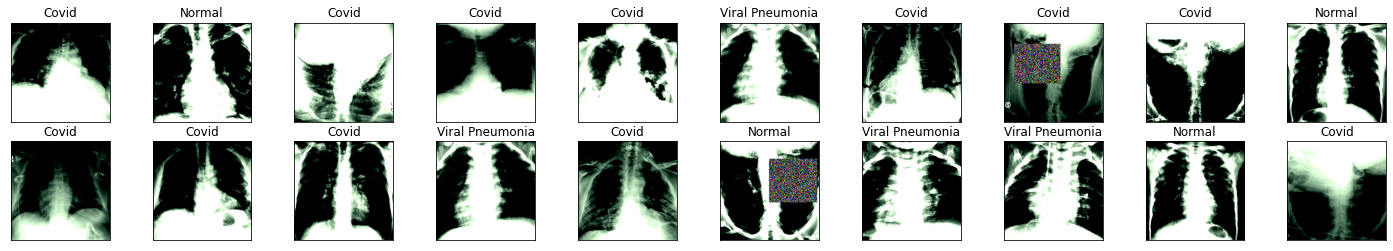

In [19]:
train_loader_iterable = iter(train_dataloader)

images, labels = train_loader_iterable.next()

print('labels list is ', labels)

# Now for displaying I have to convert images to Numpy
images = images.numpy()
# plt.imshow(images[1][1]) # this is will display this image

# Plot images in batch along with corresponding labels.
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[] )
  plt.imshow(np.transpose(images[idx], (1,2,0)))
  # in above line transpose should convert
  # a `[channel, height, width]` tensor to a `[height, width, channel]` one.
  
  ax.set_title(class_categories[labels[idx]])

## Load `efficientnet_b0` from torchvision Models

In [20]:
torch.backends.cudnn.benchmark = True

model = models.efficientnet_b0(pretrained=True)

print("model.classifier is => ", model.classifier)

""" model.classifier is =>  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
"""

for param in model.parameters():
  param.requires_grad = False
  
num_inputs = model.classifier[1].in_features


""" Now here is where I am adding additional layers to the pre-trained model.

for nn.Linear - note the following
in_features – size of each input sample
out_features – size of each output sample

"""


model.classifier = nn.Sequential(
  nn.Linear(num_inputs, 2048),
  nn.SiLU(), # Sigmoid Weighted Linear Unit
  nn.Dropout(0.2),
  # Note that the last layer is 2048 * Number of Classes
  # Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
  nn.Linear(2048, len(class_categories))
)

model = model.to(device)
print(model.classifier)



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

model.classifier is =>  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=3, bias=True)
)


## What does `torch.backends.cudnn.benchmark = True` does

It enables benchmark mode in cudnn, and so allowing you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.

Benchmark mode is good whenever your input sizes for your network do not vary. This way, cudnn will look for the optimal set of algorithms for that particular configuration (which takes some time). This usually leads to faster runtime.

But if your input sizes changes at each iteration, then cudnn will benchmark every time a new size appears, possibly leading to worse runtime performances. Because, each new input shape will rerun `cudnnFind` to find the fastest kernel for this shape (for all layers with a new input shape) and will add these kernels to a cache.

If your input always have the same size, you should enable it all the time.

However, if your model changes: for instance, if you have layers that are only "activated" when certain conditions are met, or you have layers inside a loop that can be iterated a different number of times, then setting torch.backends.cudnn.benchmark = True might stall your execution.

In [21]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001 )

### Formula of Label Smoothing

Label smoothing replaces one-hot encoded label vector y_hot with a mixture of y_hot and the uniform distribution:


## y_ls = (1 - α) * y_hot + α / K

In [22]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)
# Change the learning rate based on number of epochs
# Decays the learning rate of each parameter group by gamma every step_size epochs

In [ ]:
training_history = {'accuracy': [], 'loss':[] }
validation_history = {'accuracy': [], 'loss': []}

## Training the Model

```py
dataloaders_dict = {
  'train': train_dataloader,
  'validation': validation_dataloader
}

dataset_sizes_dict = {
  'train':len_train_dataloader,
  'validation': len_validation_dataloader
}

```

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
  start_time = time.time()
  
  best_model_weights = copy.deepcopy(model.state_dict())
  best_accuracy = 0.0
  
  for epoch in range(num_epochs):
    print('Running epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    """ Within each epoch first configure training or eval mode 
    based on wheather I am in the 'train' or 'validation' phase.
    
    `model.train()` tells your model that you are training the model. So effectively layers like dropout, batchnorm etc.
     which behave different on the train and test procedures know what is going on and hence can behave accordingly.
    
    In below, after I start the for loop for phase, the rest entire code for this train() function runs
    within this for loop and at various stage passing the phase variable to be either 'train' or 
    'validation'
    
    """
    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0
      
      """ now start the iteration of the dataloaders_dict variable
      i.e. for both 'train' and 'validation' phases 
      
      Below loop, basically tells that, for every epoch the train_dataloader and then the validation_dataloader is invoked
       which returns input and its corresponding label. 
      
      """
      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        """ for every mini-batch during the training phase, we typically want to explicitly set the gradients 
        to zero before starting to do backpropragation """
        optimizer.zero_grad()
        
        """ Start the forward movement
        tracking history for phase == 'train' 
        set_grad_enabled is a Context-manager that sets gradient calculation to on or off.

        The argument to it is called mode (which is a boolean ), and this mode controls whether to enable grad (True), 
        or disable (False). This can be used to conditionally enable gradients.
        """
        with torch.set_grad_enabled(phase == 'train'):
          predicted_outputs = model(inputs)          
          # print('outputs on which to apply torch.max ', outputs)
          # find the maximum along the rows, use dim=1 to torch.max()
          _, predictions = torch.max(predicted_outputs, 1)
          
          loss = criterion(predicted_outputs, labels)
          
          # Now for the 'train' phase, do backpropagation and update weights with step()
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        """ Update the running loss and corrects 
        we need to use, loss.item() instead of loss alone in running_loss calculation and averaging. 
        Because loss gives you a grad_function, not a float value. 
        The item() method extracts the loss’s value as a Python float.
        """
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predictions == labels.data)
        
      if phase == 'train':
        scheduler.step()      
      
      epoch_loss = running_loss / dataset_sizes_dict[phase]
      epoch_accuracy = running_corrects.double() / dataset_sizes_dict[phase]
      
      """ To summarize, in the above code what I did is
      
      1. => multiply each average batch loss with batch-length. 
      The batch-length is inputs.size(0) which gives the number total images in each batch. 
      Essentially I am un-averaging the Batch-Loss

      Do this all the batches inside the batch-running loop.
      And then after that loop, i.e. outside the batch-loop and coming back to my epoch-loop
      
      2. => Divide this accumulated un-averaged Batch-loss from all batches, 
      by the number of samples (len(train_dataloader)) to get the exact train loss average for the epoch """
      
      
      if phase == 'train':
        training_history['loss'].append(epoch_loss)
        training_history['accuracy'].append(epoch_accuracy)
      elif phase == 'validation':
        validation_history['loss'].append(epoch_loss)
        validation_history['accuracy'].append(epoch_accuracy)
        
      # finally update best_accuracy and deep copy the model
      if phase == 'validation' and epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_model_weights = copy.deepcopy(model.state_dict())
  
  time_elapsed = time.time() - start_time
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60
  ))
  print('Best Validation Accuracy: {:4f}'.format(best_accuracy))
  
  # loading best model weights
  model.load_state_dict(best_model_weights)
  return model

# Explanation on the train() method above

### Why Using torch.max() Function to the get the Predictions from output of `model(input)`

In above I used the code

```py
predicted_outputs = model(inputs)          
# print('outputs on which to apply torch.max ', outputs)
# find the maximum along the rows, use dim=1 to torch.max()
_, predictions = torch.max(predicted_outputs, 1)

```

To understand how this works, just check below how max() function works

The default behavior is to return a single element and an index, corresponding to the global maximum element.

```py

p = torch.randn([2, 3])
print(p)

tensor([[-0.0665,  2.7976,  0.9753],
        [ 0.0688, -1.0376,  1.4443]])

max_element = torch.max(p)
print(max_element)

tensor(2.7976)

```

Indeed, this gives us the global maximum element in the Tensor!

---------------------------------------------------------------------


### Use torch.max() along a dimension

=> Dim 0 maximum along columns i.e. max value in each column.

=> Dim 1 maximum along Rows i.e. max value in each Row.



So to get the maximum along a particular dimension, as a Tensor, instead of a single element.

The dimension is axis – in numpy.

**This returns a tuple, max_elements and max_indices.**

max_elements -> All the maximum elements of the Tensor.
max_indices -> Indices corresponding to the maximum elements.

---------------------------------------------------------------------


### To find the maximum along the rows, use dim=1.

# Get the maximum along dim = 1 (axis = 1)

```py

p = torch.randn([2, 3])
print(p)

''' tensor([[-0.0665,  2.7976,  0.9753],
        [ 0.0688, -1.0376,  1.4443]]) '''

max_elements, max_idxs = torch.max(p, dim=1)

print(max_elements)
# tensor([2.7976, 1.4443]) # Because in first row max is 2.7976 and in second row max is 1.4443

print(max_idxs)
# tensor([1, 2])

```

Indeed, we get the maximum elements along the row, and the corresponding index (along the row).

---

### What is `state_dict` in above code

A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict.


### What's the difference between state_dict and parameters()?

The parameters() only gives the module parameters i.e. weights and biases.

On the other hand, state_dict returns a dictionary containing a whole state of the module.

For example, in state_dict, you'll find entries like `bn1.running_mean` and `running_var`, which are not present in `.parameters()`.

PyTorch internally relies on Python's pickle module. Python dictionary can easily be pickled, unpickled, updated, and restored. Thus saving model using state_dict offers more flexibility.


You can also save the optimizer state, hyperparameters, etc., as key-value pairs along with the model's state_dict. When restored, you can access them just like your usual Python dictionary.


---

###  why loss.item() is multiplied with batch size

It's because the loss given by CrossEntropy or other loss functions is divided by the number of elements i.e. the reduction parameter is mean by default.

```
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
```

Hence, loss.item() contains the loss of entire mini-batch, but divided by the batch size i.e. number of samples per batch.

That's why loss.item() is multiplied with batch size, given by inputs.size(0), while calculating running_loss.

**Note that inputs.size(0) would give the total images in each batch.**


loss is a tensor just like every other tensor. In general the PyTorch APIs return avg loss by default

"The losses are averaged across observations for each minibatch."


Further,  we use `t.item()` to maintain running loss instead of `t` because PyTorch tensors store history of its values which might overload your GPU very soon.

---


So in the above code what it did is

=> multiply each batch loss with its length

=> and divide this accumulated loss by the number of samples (len(test_dataset)) to get the exact test loss average.


So again to sum up,

 A. The loss returned by PyTorch is an average over all examples in a batch.

 B. So that means at the end of an epoch, you will have the sum of all Batch Losses.

 B. Given this, you could simply divide the running loss by the number of batches.

 C. However since the final batch is often not the same size with others, your results would be inaccurate.

 D. Hence, the solution is to reverse the average by multiplying the loss in a batch by the total number of images in the batch, i.e. by `inputs.size(0)`

 E. This gives un-averaged sum of losses over all examples.

 F. So finally, when you divide that un-averaged running loss by the total number of images, you get accurate loss metrics which is the average loss over all images in your entire training dataset.

In [ ]:
model_trained = train(model, criterion, optimizer, exp_lr_scheduler, num_epochs=150)

# Final Evaluation on the Test Dataset

In [ ]:
def evaluate(model):
  loss_on_test_dataset = 0.0
  correct_class = list(0. for i in range(len(class_categories)))
  total_correct_for_all_classes = list(0. for i in range(len(class_categories)))
  
  model.eval()
  
  for test_inputs, test_labels in tqdm(test_dataloader):
    # In local machine, below 2 Lines will NOT work if local GPU
    # itself or the GPU's Compute Capability is NOT compatible with PyTorch
    if torch.cuda.is_available():
      test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()
    
    with torch.no_grad():
      output_test = model(test_inputs)
      loss = criterion(output_test, test_labels)
    
    loss_on_test_dataset += loss.item() * test_inputs.size(0)
    _, pred_test = torch.max(output_test, 1)
    
    """ 
    Now compare predictions to true label
    
    view_as => View this tensor as the same size as other. 
    self.view_as(other) is equivalent to self.view(other.size()).   
    tensor.view_as(other) is equivalent to tensor.view(other.size())
    """
    correct_tensor = pred_test.eq(test_labels.view_as(pred_test))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # Basically above will make sure if gpu is not available then we copy the tensor to cpu and convert it to numpy array.
    
    if len(test_labels) == BATCH_SIZE:
      for i in range(BATCH_SIZE):
        label = test_labels.data[i]
        correct_class[label] += correct[i].item() # updating corrects for each class object
        total_correct_for_all_classes[label] += 1 # updating corrects for total classes
        
  loss_on_test_dataset = loss_on_test_dataset/len(test_dataloader.dataset)
  print('Test Loss: {:.6f}\n'.format(loss_on_test_dataset))
  
  for i in range(len(class_categories)):
    if total_correct_for_all_classes[i] > 0:
      # Now print total Accuracy % and also number of corrects vs total number
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        class_categories[i], 100 * correct_class[i] / total_correct_for_all_classes[i],
        np.sum(correct_class[i]), np.sum(total_correct_for_all_classes[i])
      ))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (class_categories[i]))
  
  print('\n Test Accuracy (Overall): {:.4f} ({}/{})'.format(
    100 * np.sum(correct_class) / np.sum(total_correct_for_all_classes),
    np.sum(correct_class), np.sum(total_correct_for_all_classes)
  ))
    
  

In [ ]:
evaluate(model_trained)

100%|██████████| 3/3 [00:12<00:00,  4.05s/it]

Test Loss: 0.482172

Test Accuracy of Covid: 92% (23/25)
Test Accuracy of Normal: 89% (17/19)
Test Accuracy of Viral Pneumonia: 100% (20/20)

 Test Accuracy (Overall): 93.7500 (60.0/64.0)
